## Comparing KO clusters
I need to find a good way to compare the size & persistence of KO clusters vs. their sibling clades.

In [1]:
import os
from Bio import Phylo
from augur.utils import json_to_tree
import json
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import statsmodels.api as sm
import math


In [2]:
os.chdir('/Users/cwagner2/Work/projects/covid/long-deletions/')

In [3]:
## Matplot lib settings
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize']= 14
mpl.rcParams['legend.fontsize']=12
mpl.rcParams['legend.title_fontsize']=14

### Load tree

In [4]:
#path to tree json
#tree_file = 'nextstrain_results/WA20K_2023-04-14/auspice/ncov_WA_20k.json'
tree_file = 'nextstrain_build/auspice/ncov_WA_20k.json'
with open(tree_file, 'r') as f:
    tree_json = json.load(f)

#put tree in Bio.phylo format
tree = json_to_tree(tree_json)

### Get cluster size & time

In [53]:
def tabulate_names(tree):
    names = {}
    for idx, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(idx)
        names[clade.name] = clade
    return names

def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path[-2]

def getMut(mut):
    og = mut[0]
    pos = ''.join(mut[1:-1])
    new = mut[-1]
    return og,pos,new

def getMutType(muts,gene,start,end):
    if 'nuc' in muts.keys():
        all_nucs = [getMut(mut) for mut in muts['nuc']]
        nucsGene = [nuc for nuc in all_nucs if int(nuc[1])>= start and int(nuc[1])<end+1 and nuc[0] != '-' and nuc[2] != '-']
        if gene in muts.keys():
            all_ns = [getMut(mut) for mut in muts[gene]]
            nucNSList = [set(range(start - 2 + (int(mut[1])*3),start+ 1 +(int(mut[1])*3))) for mut in all_ns]
            nucNS = set.union(*nucNSList)
            syn = [''.join(nuc) for nuc in nucsGene if int(nuc[1]) not in nucNS]
            stops = [''.join(mut) for mut in all_ns if mut[2] == '*' or mut[0] == '*']
            ns = [''.join(mut) for mut in all_ns if mut[2] != '*' and mut[0] != '*' and mut[2] != '-' and mut[0] != '-'] # gaps & stops are not NS
        else:
            syn = [''.join(nuc) for nuc in nucsGene]
            stops = []
            ns = []
    else:
        syn = []
        stops = []
        ns = []
    output = {}
    output['syn'] = syn
    output['nonsyn'] = ns
    output['stops'] = stops
    return output

def geneLocs(path):
    pos = {}
    ref = SeqIO.read(path,'gb')
    for feature in ref.features:
        if feature.type == "CDS":
            start = feature.location.start
            end = feature.location.end
            name = feature.qualifiers['gene'][0]
            pos[name] = {}
            pos[name]['end'] = end
            pos[name]['start'] = start
    return pos

def compareKO(subtree,gene,start,end,leafs,mutType):
    clusters = {}
    count = 1
    for clade in subtree.find_clades():
        inWA = clade.node_attrs['inWA']['value']
        if inWA:
            all_muts = clade.branch_attrs['mutations']
            #total_aa = [v for k,v in all_muts.items() if k != 'nuc'] ## NEW only look at clusters with one amino acid mutation
            #if len(total_aa) == 1: ## SAME AS last line
            muts = getMutType(all_muts,gene,start,end)

            n = np.sum([len(v) for k,v in muts.items()]) # Add back in if 1 mut only
            if n == 1: # add back in if 1 mut only
                if len(muts[mutType]):
                    s = muts[mutType]

                    parent = get_parent(subtree,clade)
                    parentTime = parent.node_attrs['num_date']['value']
                    parentDiv = parent.node_attrs['div']
                    if parent.node_attrs['inWA']['value']:
                        clusters[count] = {}
                        clusters[count]['ko'] = {}

                        clusters[count]['ko']['node'] = clade.name
                        clusters[count]['ko']['mut'] = s
                        strains = clade.get_terminals()
                        clusters[count]['ko']['clusterSize'] = len(strains)
                        times = [strain.node_attrs['num_date']['value'] for strain in strains]
                        clusters[count]['ko']['persistence'] = max(times) - min(times)
                        clusters[count]['noko'] = {}
                        clusters[count]['noko']['clusterSize'] = []
                        clusters[count]['noko']['persistence'] = []

                        for sib in parent.find_clades():
                            sibDiv = sib.node_attrs['div']
                            if sib in parent and sib != clade:
                                if sibDiv != parentDiv: ## So polytomies don't get counted
                                    sib_muts = sib.branch_attrs['mutations'] #ADD BACK IN IF WANT 1 MuT ONLY
                                    if len(sib_muts) < 2:  # ADD BACK IN IF 1 MUT ONLY
                                        terms = sib.get_terminals()
                                        clusters[count]['noko']['clusterSize'].append(len(terms))
                                        newTimes = [names[strain.name].node_attrs['num_date']['value'] for strain in terms]
                                        clusters[count]['noko']['persistence'].append(max(newTimes) - min(newTimes))

                        count += 1
    return clusters

def aggClusters(clusters,mutType,gene):
    node_id = []
    sizes = []
    times = []
    clade = []
    clust = []
    all_clusters = clusters.keys()
    for cluster in all_clusters:
        ided = clusters[cluster]['ko']['node']
        sizes.append(clusters[cluster]['ko']['clusterSize'])
        times.append(clusters[cluster]['ko']['persistence'])
        clade.append('mut')
        clust.append(cluster)
        sibSizes = clusters[cluster]['noko']['clusterSize']
        sizes.extend(sibSizes)
        times.extend(clusters[cluster]['noko']['persistence'])
        clade.extend(['nomut']*len(sibSizes))
        clust.extend([cluster]*len(sibSizes))
        node_id.extend([ided]*(len(sibSizes)+1))
    df = pd.DataFrame({'size':sizes,'time':times,'cladeType':clade,'mutType':mutType,'cluster':clust,'gene':gene, 'ko_node':node_id})
    return df

def get_df(geneDict, leafs):
    dfs = []
    for gene in geneDict.keys():
        for mutType in ['stops','nonsyn','syn']:
            clustDict = compareKO(tree,gene, geneDict[gene]['start'],geneDict[gene]['end'],leafs,mutType)
            df = aggClusters(clustDict,mutType,gene)
            dfs.append(df)
    all_df = pd.concat(dfs)
    return all_df

geneDict = geneLocs('sars2_ref.gb')
leafs = tree.get_terminals()
names = tabulate_names(tree)

In [54]:
big_df = get_df(geneDict,leafs)

### Permutation test
Permutation tests sample without replacement. My goal is to conduct it for each cluster that I have.

permutations = permute(data, P=120)
observed_median = median(data)
p_medians = [median(p) for p in permutations]
p_val = sum(p > observed_median for p in p_medians) / len(p_medians)

#### For ORF8, stops

In [55]:
rng = np.random.default_rng()

def get_percentile(df,rows,var):
    clusters = [df.at[row,'cluster'] for row in rows]
    indices = [df.loc[df.cluster==cluster].index for cluster in clusters]
    clusterRanks = [st.rankdata(df.loc[df.cluster==cluster,var]) for cluster in clusters]
    locs = [np.where(idx==row) for row, idx in zip(rows,indices)]
    rank = [clusterRank[np.where(idx==row)[0][0]] for row, idx, clusterRank in zip(rows,indices,clusterRanks)]
    clusterLengths = [len(cluster) for cluster in indices]
    percentile = np.asarray(rank)/np.asarray(clusterLengths)
    #return np.array(rank)
    return percentile

def null_percentile(df,var,size):
    rows = rng.choice(np.arange(len(df)), size=size, replace=False)
    percentile = get_percentile(df,rows,var)
    return percentile

def true_percentile(df,var):
    rows = df.loc[df.cladeType=='mut'].index
    percentile = get_percentile(df,rows,var)
    return percentile

def get_permutations(df, size):
    indices = [df[df.cluster==cluster].index for cluster in df.cluster.unique()]
    choices = np.array([rng.choice(idx,size=size,replace=True) for idx in indices],dtype=int)
    choicesList = [tuple(choices[:,col]) for col in range(size)]
    deduped = list(set(choicesList))
    arr = np.array([list(values) for values in deduped]).astype(int)
    return arr

def permutation_test(df,size,var,direct='greater'):
    truePercent = true_percentile(df,var)
    trueMean = np.mean(truePercent)
    options = get_permutations(df,int(size*1.5))
    percentiles = [get_percentile(df,options[row,:],var) for row in range(size)]
    means = np.array([np.mean(get_percentile(df,options[row,:],var)) for row in range(size)])
    if direct == 'greater':
        total = len(means[means > trueMean])
    else:
        total = len(means[means<trueMean])
    pvalue = total/size
    return pvalue, percentiles, means

def permutation_test_absolute(df,size,var,direct='greater'):
    trueRows = df.loc[df.cladeType=='mut'].index
    trueVar = df.loc[trueRows,var]
    #trueMean = np.mean(trueVar)
    
    options = get_permutations(df,int(size*1.5))
    variables = [df.loc[options[row,:],var] for row in range(size)]
    larger = [np.count_nonzero(trueVar.values>=var.values) for var in variables]
    #print(larger)
    prop = np.asarray(larger)/len(trueVar)
    #means = np.array([np.mean(df.loc[options[row,:],var]) for row in range(size)])
    if var == 'size':
        trueMean = st.gmean(trueVar)
        means = np.array([st.gmean(df.loc[options[row,:],var]) for row in range(size)])
    else:
        trueMean = np.mean(trueVar)
        means = np.array([np.mean(df.loc[options[row,:],var]) for row in range(size)])
    if direct == 'greater':
        total = len(means[means > trueMean])
    else:
        total = len(means[means<trueMean])
    pvalue = total/size
    return pvalue, variables, means,prop
    

In [56]:
stops8 = big_df[(big_df.gene=='ORF8')&(big_df.mutType=='stops')]
syn8 = big_df[(big_df.gene=='ORF8')&(big_df.mutType=='syn')]
ns8 = big_df[(big_df.gene=='ORF8')&(big_df.mutType=='nonsyn')]
#synE = big_df[(big_df.gene=='E')&(big_df.mutType=='syn')]
#nClusters = len(stops8[stops8.cladeType=='mut'])

In [57]:
stops8.head()

,size,time,cladeType,mutType,cluster,gene,ko_node
0,1.0,0.000000,mut,stops,1.0,ORF8,USA/WA-UW-10698/2020
1,8.0,0.155738,nomut,stops,1.0,ORF8,USA/WA-UW-10698/2020
2,1.0,0.000000,mut,stops,2.0,ORF8,USA/WA-UW-21759/2020
3,4.0,0.030055,mut,stops,3.0,ORF8,NODE_0005394
4,1.0,0.000000,nomut,stops,3.0,ORF8,NODE_0005394


In [45]:
big_df.loc[big_df.ko_node.str.contains('NODE_0000446'),:]

,size,time,cladeType,mutType,cluster,gene,ko_node
105,2.0,0.060109,mut,stops,34.0,ORF8,NODE_0000446
106,1.0,0.000000,nomut,stops,34.0,ORF8,NODE_0000446
107,1.0,0.000000,nomut,stops,34.0,ORF8,NODE_0000446
108,1.0,0.000000,nomut,stops,34.0,ORF8,NODE_0000446


In [58]:
orf8 = {}
for lab, dataset in zip(['nonsense','missense','synonymous'],[stops8,ns8,syn8]):
    trueRows = dataset.loc[dataset.cladeType=='mut'].index
    orf8[lab] = {}
    for var in ['size','time']:
        orf8[lab][var] = {}
        p, permut, means,larger = permutation_test_absolute(dataset,10000,var)
        true = dataset.loc[trueRows,var]
        orf8[lab][var]['pvalue'] = p
        orf8[lab][var]['permuted'] = permut
        orf8[lab][var]['means'] = means
        orf8[lab][var]['observed'] = true
        if var == 'size':
            orf8[lab][var]['mean'] = st.gmean(true)
        else:
            orf8[lab][var]['mean'] = np.mean(true)
        orf8[lab][var]['propLarger'] = larger

In [59]:
for key in orf8.keys():
    print(key)
    for var in orf8[key].keys():
        print(var)
        print(orf8[key][var]['pvalue'])
        #print(orf8[key][var]['propLarger'])
        #print(orf8[key][var]['means'])
        #print(orf8[key][var]['mean'])
    print('-------')

nonsense
size
0.5104
time
0.3979
-------
missense
size
1.0
time
1.0
-------
synonymous
size
0.9979
time
0.9996
-------


In [62]:
orf8Percentile = {}
for lab, dataset in zip(['nonsense','missense','synonymous'],[stops8,ns8,syn8]):
    trueRows = dataset.loc[dataset.cladeType=='mut'].index
    orf8Percentile[lab] = {}
    for var in ['size','time']:
        orf8Percentile[lab][var] = {}
        p, permut, means = permutation_test(dataset,1000,var)
        true = true_percentile(dataset,var)
        orf8Percentile[lab][var]['pvalue'] = p
        orf8Percentile[lab][var]['permuted'] = permut
        orf8Percentile[lab][var]['means'] = means
        orf8Percentile[lab][var]['observed'] = true
        orf8Percentile[lab][var]['mean'] = np.mean(true)

In [63]:
for key in orf8Percentile.keys():
    print(key)
    for var in orf8Percentile[key].keys():
        print(var)
        print(orf8Percentile[key][var]['pvalue'])
        print(orf8Percentile[key][var]['mean'])
    print('-------')

nonsense
size
0.033
0.8322215394140028
time
0.26
0.8112063642542786
-------
missense
size
0.425
0.8019339675772831
time
0.565
0.7978211273291022
-------
synonymous
size
0.715
0.7507168793443303
time
0.795
0.7472115883390393
-------


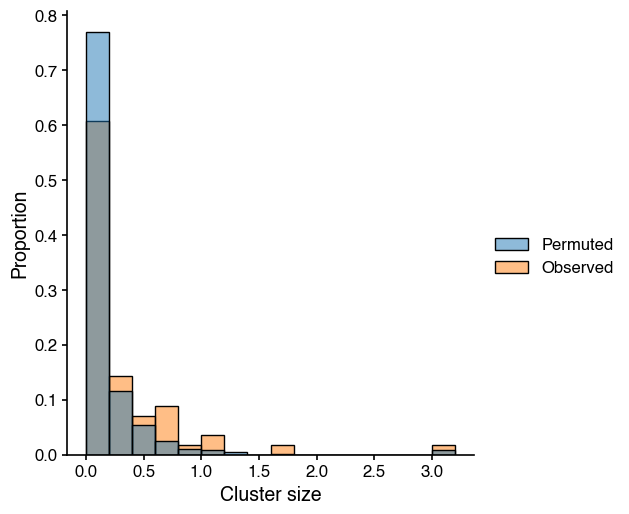

In [63]:
width = 0.2
g = sns.displot({'Permuted':np.log10(np.array(orf8['nonsense']['size']['permuted']).flatten()),'Observed':np.log10(orf8['nonsense']['size']['observed'])},kind='hist',common_norm=False,multiple='layer',stat='proportion',bins=np.arange(0,3.2+width,width))
g.set(xlabel='Cluster size')
#g.savefig('figs/clusterTime_permutation_hist.pdf')

In [49]:
def plot_permutation(diction,gene, xlab,var,x,y):
    fig,ax = plt.subplots(ncols=3,nrows=1,tight_layout=True,figsize=(9,3),sharex=True,sharey=True)
    for key,loc in zip(['nonsense','missense','synonymous'],range(3)):
        ax[loc].set_title(gene +': ' + key)
        ax[loc].set_xlabel(xlab)
        ax[loc].hist(diction[key][var]['means'],bins=100)
        mean = diction[key][var]['mean']
        ax[loc].axvline(x=diction[key][var]['mean'],c='k',linestyle='dashed')
        ax[loc].text(x,y,'pvalue: '+str(np.round(diction[key][var]['pvalue'],5)))
    return fig

In [22]:
def plot_permutation_kinda(diction,gene, xlab,var,x,y):
    fig,ax = plt.subplots(ncols=3,nrows=1,tight_layout=True,figsize=(9,3),sharex=True,sharey=True)
    for key,loc in zip(['nonsense','missense','synonymous'],range(3)):
        ax[loc].set_title(gene +': ' + key)
        ax[loc].set_xlabel(xlab)
        ax[loc].hist(diction[key][var]['propLarger'],bins=100)
        #mean = diction[key][var]['mean']
        #ax[loc].axvline(x=diction[key][var]['mean'],c='k',linestyle='dashed')
        #ax[loc].text(x,y,'pvalue: '+str(np.round(diction[key][var]['pvalue'],5)))
    return fig

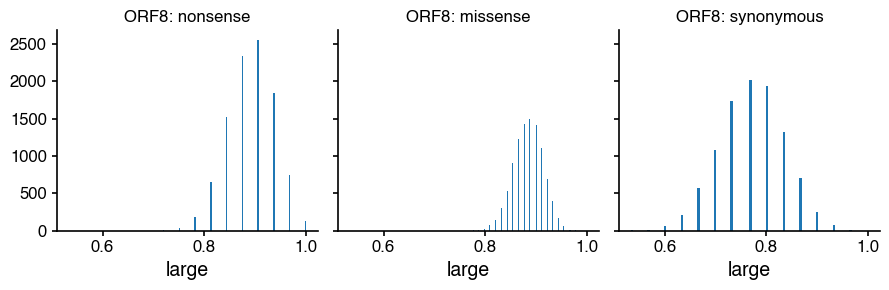

In [23]:
fig = plot_permutation_kinda(orf8,'ORF8','large','size',15,1000)

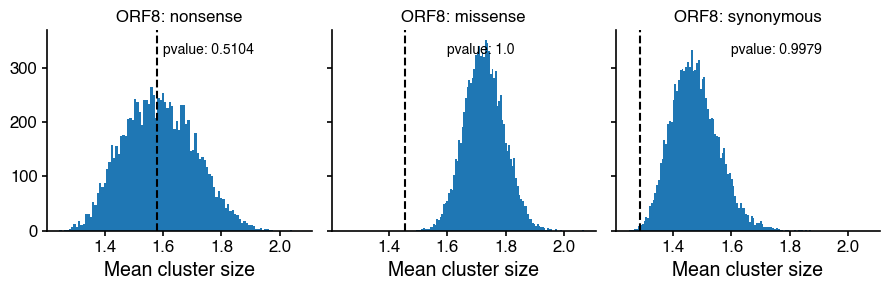

In [60]:
fig = plot_permutation(orf8,'ORF8','Mean cluster size','size',1.6,325)
#fig.savefig('figs/permutation_clusterSize.pdf')

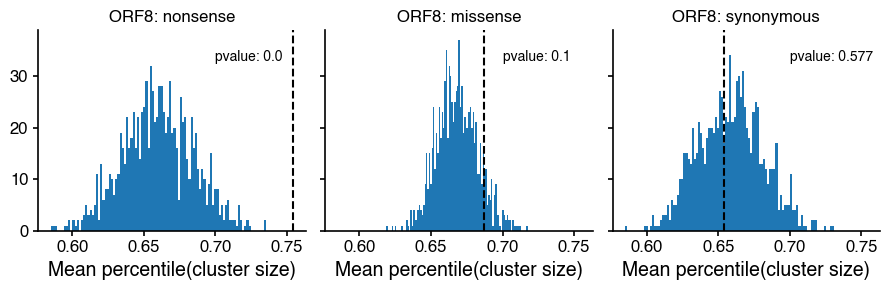

In [141]:
fig = plot_permutation(orf8Percentile,'ORF8','Mean percentile(cluster size)','size',0.7,33)
fig.savefig('figs/permutationPercentile_clusterSize.pdf')

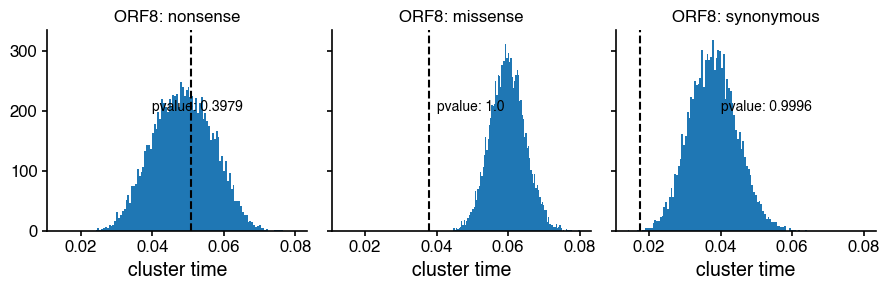

In [61]:
fig = plot_permutation(orf8,'ORF8','cluster time','time',0.04,200)
#fig.savefig('figs/permutation_clusterTime.pdf')

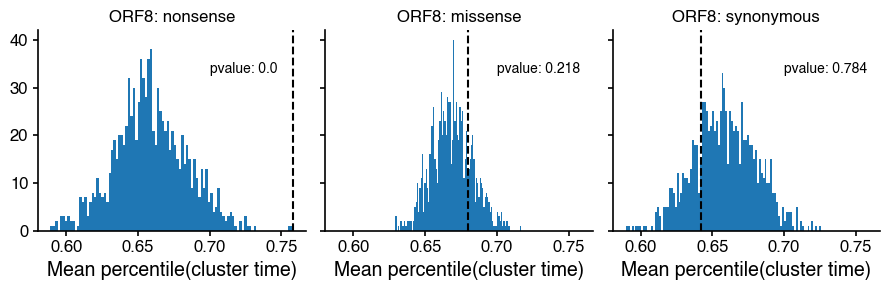

In [142]:
fig = plot_permutation(orf8Percentile,'ORF8','Mean percentile(cluster time)','time',0.7,33)
fig.savefig('figs/permutationPercentile_clustertime.pdf')

In [26]:
pTime_stops8, times_stops8 = permutation_test_absolute(stops8,10000,'time')
pTime_stops8

0.0

In [ ]:
pSize_syn8, sizes_syn8 - p

In [101]:
nullPercentile = null_percentile(stops8,'time',len(stops8))
truePercentileTime = true_percentile(stops8,'time')
trueSize = true_percentile(stops8,'size')

In [348]:
pSize,sizePercentiles = permutation_test(stops8,1000,'size')

In [102]:
pTime,timePercentiles = permutation_test(stops8,1000,'time')

In [352]:
pTime8syn,timePer8syn = permutation_test(syn8,1000,'time','lesser')
#pTime8ns,timePer8ns = permutation_test(ns8,1000,'time')

pSize8syn,sizePer8syn = permutation_test(syn8,1000,'size','lesser')
#pSize8ns,sizePer8ns = permutation_test(ns8,1000,'size')

In [353]:
pTime8syn

0.229

In [345]:
pTime8ns

0.216

In [354]:
pSize8syn

0.438

In [347]:
pSize8ns

0.1

In [268]:
pTimeEsyn

0.481

In [351]:
pTime

0.0

In [350]:
pSize

0.0

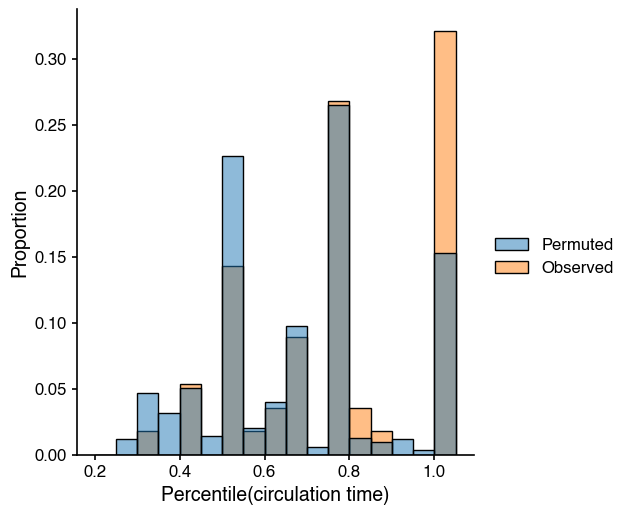

In [110]:
width=0.05
g = sns.displot({'Permuted':np.array(timePercentiles).flatten(),'Observed':truePercentileTime},kind='hist',common_norm=False,multiple='layer',stat='proportion',bins=np.arange(0.2,1+width+width,width))
g.set(xlabel='Percentile(circulation time)')
g.savefig('figs/clusterTime_permutation_hist.pdf')

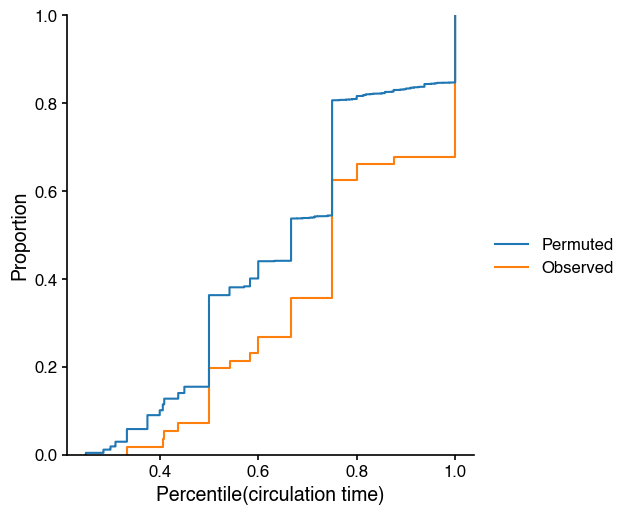

In [108]:
width=0.05
g = sns.displot({'Permuted':np.array(timePercentiles).flatten(),'Observed':truePercentileTime},kind='ecdf')
g.set(xlabel='Percentile(circulation time)')
#g.savefig('figs/clusterTime_permutation_ecdf.pdf')

In [333]:
def ecdf(data,xlab):
    g = sns.displot(data,kind='ecdf')#,bins=np.arange(0.2,1+width,width))
    g.set(xlabel=xlab)
    return g

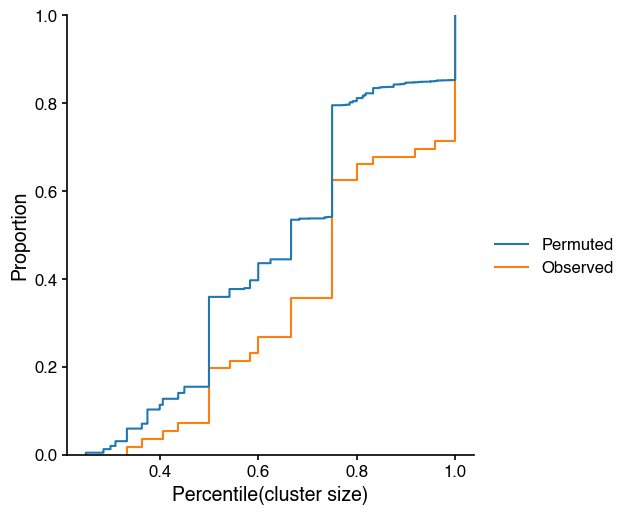

In [331]:
width=0.2
g = sns.displot({'Permuted':np.array(sizePercentiles).flatten(),'Observed':trueSize},kind='ecdf')#,bins=np.arange(0.2,1+width,width))
g.set(xlabel='Percentile(cluster size)')
g.savefig('figs/clusterSize_permutation_ecdf.pdf')

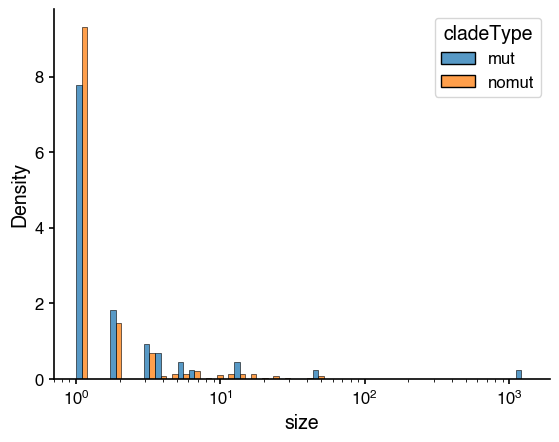

In [10]:
ax = sns.histplot(data=stops8,x='size',hue='cladeType', stat='density',log_scale=True, common_norm=False,multiple='dodge')
fig = ax.get_figure()
fig.savefig('figs/size_hist_sibs.pdf', bbox_inches='tight',dpi=300)

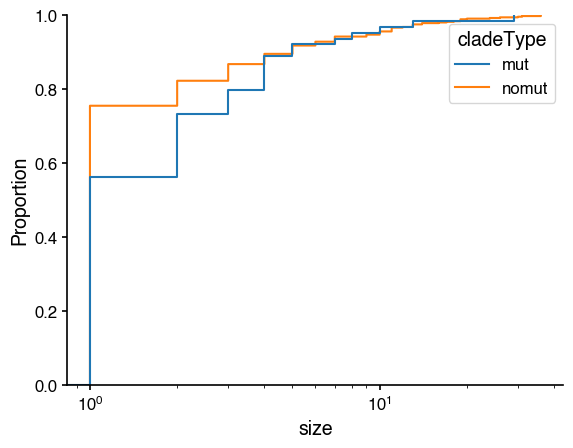

In [107]:
ax = sns.ecdfplot(data=stops8,x='size',hue='cladeType', stat='proportion',log_scale=True)
fig = ax.get_figure()
#fig.savefig('figs/size_ecdf_sibs.pdf', bbox_inches='tight',dpi=300)

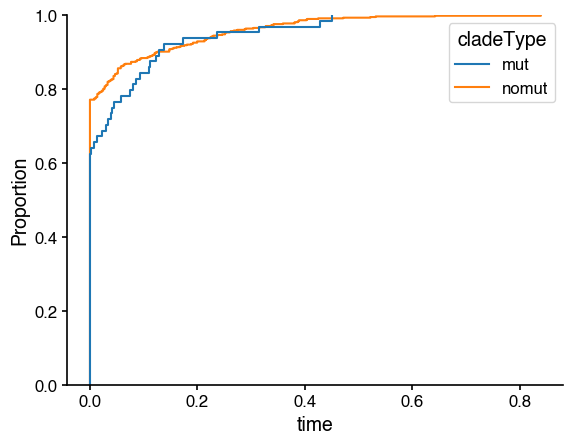

In [108]:
ax = sns.ecdfplot(data=stops8,x='time',hue='cladeType', stat='proportion')
fig = ax.get_figure()
#fig.savefig('figs/time_ecdf_sibs.pdf', bbox_inches='tight',dpi=300)

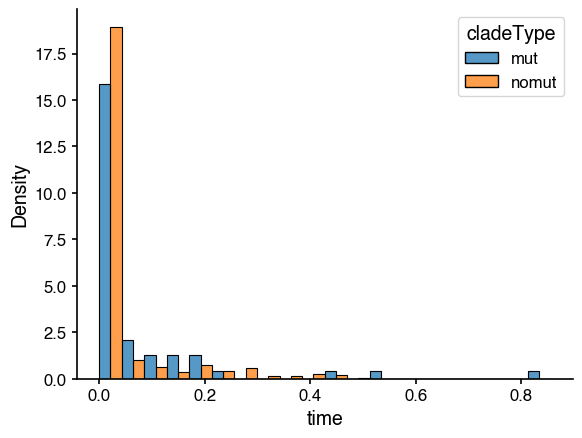

In [11]:
ax = sns.histplot(data=stops8,x='time',hue='cladeType', stat='density',common_norm=False,multiple='dodge', bins=20)
fig = ax.get_figure()
fig.savefig('figs/time_hist_sibs.pdf', bbox_inches='tight',dpi=300)

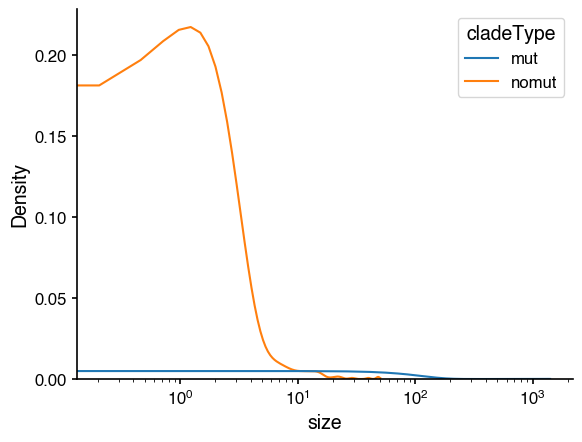

In [171]:
ax = sns.kdeplot(data=stops8,x='size',hue='cladeType',cut=True,common_norm=False)
ax.set_xscale('log')

In [12]:
max(stops8['cluster'])

56.0

In [39]:
mpl.rcParams['axes.spines.bottom'] = True

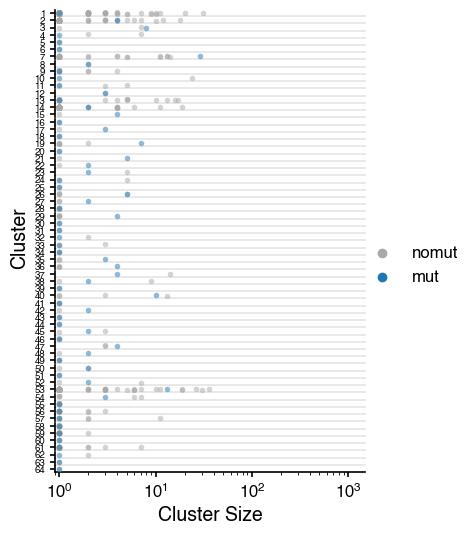

In [103]:
clusters = stops8['cluster'].unique()
n = len(clusters)
fig, ax = plt.subplots(nrows=n,figsize=(4,6))
for cluster in clusters:
    loc = int(cluster - 1)
    ax[loc].set_xscale('log')
    ax[loc].set_yticks([0],[int(cluster)],fontsize=7)
    ax[loc].set_xlim([0.9,1500])
    if loc != max(clusters)-1:
        ax[loc].set_xticks([])
        ax[loc].spines['bottom'].set_alpha(0.1)
        ax[loc].minorticks_off()
        ax[loc].set_xlabel('')
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='nomut')], c='darkgrey', x='size', ax = ax[loc],size=4, legend = False,alpha=0.5)
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='mut')], x='size', ax = ax[loc],size=4, legend = False, alpha=0.5)
    else:
        ax[loc].set_xlabel('Cluster Size')
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='nomut')], palette=['darkgrey'], x='size', hue='cladeType', ax = ax[loc],size=4,alpha=0.5)
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='mut')], x='size', hue='cladeType', ax = ax[loc],size=4, alpha=0.5)
        ax[loc].legend(bbox_to_anchor=(1.35,40), frameon=False)
    if loc == int(n/2)-1:
        ax[loc].set_ylabel('Cluster')
#fig.savefig('figs/clusterSize_allclusters.pdf',bbox_inches='tight',dpi=300)

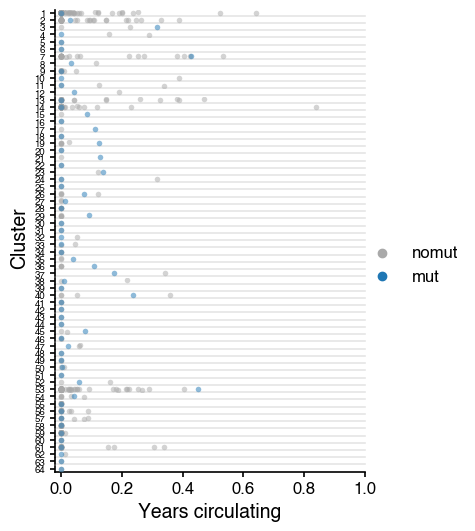

In [104]:
clusters = stops8['cluster'].unique()
n = len(clusters)
fig, ax = plt.subplots(nrows=n,figsize=(4,6))
for cluster in clusters:
    loc = int(cluster - 1)
    ax[loc].set_yticks([0],[int(cluster)],fontsize=7)
    ax[loc].set_xlim([-0.02, 1])
    if loc != max(clusters)-1:
        ax[loc].set_xticks([])
        ax[loc].spines['bottom'].set_alpha(0.1)
        ax[loc].minorticks_off()
        ax[loc].set_xlabel('')
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='nomut')], c='darkgrey', x='time', ax = ax[loc],size=4, legend = False,alpha=0.5)
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='mut')], x='time', ax = ax[loc],size=4, legend = False, alpha=0.5)
    else:
        ax[loc].set_xlabel('Years circulating')
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='nomut')], palette=['darkgrey'], x='time', hue='cladeType', ax = ax[loc],size=4,alpha=0.5)
        sns.stripplot(data=stops8[(stops8.cluster==cluster) & (stops8.cladeType=='mut')], x='time', hue='cladeType', ax = ax[loc],size=4, alpha=0.5)
        ax[loc].legend(bbox_to_anchor=(1.35,40), frameon=False)
    if loc == int(n/2)-1:
        ax[loc].set_ylabel('Cluster')
#fig.savefig('figs/clusterTime_allclusters.pdf',bbox_inches='tight',dpi=300)